In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
from keras.datasets import fashion_mnist
def load_data():
  (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)
  return (X_train, y_train), (X_test, y_test)

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

In [4]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def preprocess_data(data):
  scaler = StandardScaler()
  data_std = scaler.fit_transform(data)
  n_components = 30
  pca = PCA(n_components=n_components)
  data_pca = pca.fit_transform(data_std)
  return data_pca

In [5]:
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

In [6]:
train_data_0 = pd.DataFrame(X_train[y_train == 0])
train_data_1 = pd.DataFrame(X_train[y_train == 1])[:1000]
train_data = pd.DataFrame(pd.concat([train_data_0,train_data_1]))
train = train_data.reset_index(drop = True)

train_label_0 = pd.DataFrame(y_train[y_train == 0])
train_label_1 = pd.DataFrame(y_train[y_train == 1])[:1000]
train_data_label = pd.DataFrame(pd.concat([train_label_0,train_label_1]))
y_train = np.array(train_data_label.reset_index(drop = True))
#y_train = np.array([0 if elem==1 else 1 for elem in y_train])

In [7]:
test_data_0 = pd.DataFrame(X_test[y_test.flatten() == 0])
test_data_1 = pd.DataFrame(X_test[y_test.flatten() == 1])[:200]
test_data = pd.DataFrame(pd.concat([test_data_0,test_data_1]))
test = test_data.reset_index(drop = True)

test_label_0 = pd.DataFrame(y_test[y_test == 0])
test_label_1 = pd.DataFrame(y_test[y_test == 1])[:200]
test_data_label = pd.DataFrame(pd.concat([test_label_0,test_label_1]))
y_test = np.array(test_data_label.reset_index(drop = True))
#y_test = np.array([0 if elem==1 else 1 for elem in y_test])

In [8]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [9]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

##**Parameter Estimaion**

In [10]:
def moment_initialization(data):
  mean = np.mean(data,axis=0)
  mean_square = np.mean(data**2,axis=0)
  alpha = np.zeros(data.shape[1])
  for k in range(data.shape[1]):
    alpha[k] = mean[k]*(mean[k]-mean_square[k])/(mean_square[k]-(mean[k])**2)
  return alpha

In [11]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_lbl(row,theta):
  alpha_K, alpha, beta, lamda = theta[:len(theta)-3], theta[len(theta)-3], theta[len(theta)-2], theta[len(theta)-1]
  c = gammaln(np.sum(alpha_K)) + gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta)
  q1 = (alpha-np.sum(alpha_K))*np.log(np.abs(1-np.mean(row))) + alpha*np.log(lamda)
  q2 = (alpha+beta)*np.log(np.abs(1-(1-lamda)*(1-np.mean(row)))) - (beta-1)*np.log(np.abs(np.mean(row)))
  q3 = np.sum(((alpha_K)-1)*np.log(row)) - np.sum(np.log(alpha_K))
  return c+q1+q2+q3

In [12]:
def normalize_theta(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [13]:
def calcul_inv_hess_vect(data,theta):
  alpha = theta[:len(theta)-3]
  (N, K) = data.shape
  q = N*float(polygamma(1,np.sum(alpha)))
  inv_S = np.diag([-N/np.clip(float(polygamma(1,alpha[m])),10**(-7),None) for m in range(K)])
  a = np.ones(K).reshape(-1,1)
  inv_hess = inv_S + np.dot(np.dot(inv_S,a),np.dot(np.transpose(a),inv_S))/((1/q)*np.dot(np.dot(np.transpose(a),inv_S),a))
  return inv_hess

In [14]:
def calcul_inv_hess_non_vect(data,theta):
  (N, K) = data.shape
  H = np.zeros((3,3))
  alpha, beta, lamda = theta[len(theta)-3], theta[len(theta)-2], theta[len(theta)-1]
  H[0][0] = N*(float(polygamma(1,alpha+beta)) - float(polygamma(1,alpha)))
  H[1][1] = N*(float(polygamma(1,alpha+beta)) - float(polygamma(1,beta)))
  H[2][2] = N*((alpha+beta) / ((1-(1-lamda))**2) - (alpha/(lamda**2)))
  H[0][1] = H[1][0] = N*float(polygamma(1,alpha+beta))
  H[0][2] = H[2][0] = N*((1/lamda) - (1/(1-(1-lamda))))
  H[1][2] = H[2][1] = -N*(1/(1-(1-lamda)))
  inv_H = np.linalg.inv(H)
  return inv_H

In [15]:
def derivative(data,theta_old):
  (N, K) = data.shape
  der_vect_alpha = np.zeros(K)
  vect_alpha_old, alpha_old, beta_old, lamda_old = theta_old[:len(theta_old)-3], theta_old[len(theta_old)-3], theta_old[len(theta_old)-2], theta_old[len(theta_old)-1]
  for s in range(K):
    der_vect_alpha[s] =N*(psi(np.sum(vect_alpha_old)) - psi(vect_alpha_old[s])) - np.sum(np.log(data[:,s]) )
  der_alpha = N*(psi(alpha_old+beta_old)-psi(alpha_old) + np.log(np.clip(lamda_old,10**(-6),None))-np.log(np.clip(1-(1-lamda_old),10**(-6),None)))
  der_beta = N*(psi(alpha_old+beta_old)-psi(beta_old)- np.log(np.clip(1-(1-lamda_old),10**(-8),None)))
  der_lamda = N*((alpha_old/lamda_old) - (alpha_old+beta_old)/(1-(1-lamda_old)))
  der_theta = np.concatenate((der_vect_alpha, der_alpha,der_beta, der_lamda), axis=None)
  return der_theta

In [16]:
def update_theta(data,theta_old):
  inv_hess_vect = calcul_inv_hess_vect(data,theta_old)
  inv_hess_non_vect = calcul_inv_hess_non_vect(data,theta_old)
  der_param = derivative(data,theta_old)

  vect_alpha_old, alpha_beta_lamda_old = theta_old[:len(theta_old)-3], theta_old[len(theta_old)-3:]
  der_vect_alpha_old, der_alpha_beta_lamda_old = der_param[:len(der_param)-3], der_param[len(der_param)-3:]

  vect_alpha_new = vect_alpha_old - np.dot(inv_hess_vect,der_vect_alpha_old)
  vect_alpha_new = normalize_theta(vect_alpha_new,0.1,3)
  alpha_beta_lamda_new = alpha_beta_lamda_old - np.dot(inv_hess_non_vect,der_alpha_beta_lamda_old)
  alpha_beta_lamda_new = normalize_theta(alpha_beta_lamda_new,0.1,3)
  theta_new = (np.clip(np.concatenate((vect_alpha_new,alpha_beta_lamda_new), axis=None),10**(-15),None))

  return theta_new

In [17]:
theta_zero =  [3.48402655, 4.08689877, 2.29453679, 0.80298193, 2.48411133, 4.10905099,
 4.04348271, 0.37933385, 1.4785416,  0.75021676, 3.72930329, 0.15539801,
 4.82896634, 1.1950735,  1.39257066, 3.03847116, 0.67013932, 1.0827499,
 4.35099797, 3.31773473, 0.80319742, 1.79804192, 1.83120125, 0.89466128,
 3.35068531, 4.61107156, 1.2307713 , 4.27240379, 1.08712891, 3.98975947,
 3.14513314, 2.58677362, 2.5098388]

In [18]:
'''#theta_zero = np.concatenate((moment_initialization(train),np.random.uniform(low=0.1, high=1, size=(3,))), axis=None)
theta_zero = np.random.uniform(low=0.1, high=5, size=(train.shape[1]+3,))
print('theta_zero = ',np.array(theta_zero))'''
theta_old = theta_zero

In [19]:
max_iter = 5
for j in range(max_iter):
  theta_new = update_theta(train,theta_old)
  theta_old = theta_new

##**Feature mapping**

In [20]:
train_df = pd.DataFrame(train)
#train_df['new_feature'] = normalize_theta([log_lbl(row,theta_new) for row in train],10,20)
train_df['new_feature'] = [log_lbl(row,theta_new) for row in train]

test_df = pd.DataFrame(test)
#test_df['new_feature'] = normalize_theta([log_lbl(row,theta_new) for row in test],10,20)
test_df['new_feature'] = [log_lbl(row,theta_new) for row in test]

In [21]:
train_f = np.array(train_df)
test_f = np.array(test_df)

In [22]:
from sklearn.svm import SVC
# Train SVM classifier
print("Training SVM classifier...")
svm = SVC(kernel='poly', C=100.0, degree=3, gamma='auto', random_state=42)
svm.fit(train_f, y_train)

Training SVM classifier...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=100.0, gamma='auto', kernel='poly', random_state=42)

In [23]:
# Test SVM classifier
print("Testing SVM classifier...")
y_pred_svm = svm.predict(test_f)

Testing SVM classifier...


In [24]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics
# Evaluate the performance of the classifier
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

F1 Score: 0.9173333333333332
Precision: 0.9828571428571429
Recall: 0.86
Confusion Matrix:
 [[997   3]
 [ 28 172]]
Accuracy: 0.9741666666666666


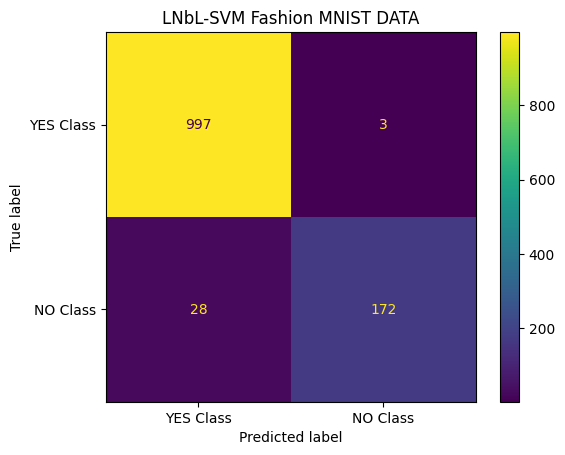

In [25]:
cm = confusion_matrix(y_test, y_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['YES Class', 'NO Class'])
cm_display.plot()
cm_display.ax_.set_title('LNbL-SVM Fashion MNIST DATA')
plt.show()